In [48]:
import glob
import sys

import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns 

sys.path.append('../land-eligibility/src/')
from utils import read_config
sys.path.append('../src/construct/')
import util

config = read_config('../config/default.yaml')

idx = pd.IndexSlice

END_USE_CAT_NAMES = {
    'FC_OTH_HH_E_CK': 'cooking',
    'FC_OTH_HH_E_SH': 'space_heating',
    'FC_OTH_HH_E_WH': 'water_heating'
}

END_USE_CARRIER_NAMES = {  # we keep these carriers, since we don't want fossils subcategories but we do want renewables subcategories
    'E7000': 'electricity',
    'G3000': 'natural_gas',
    'H8000': 'heat',
    'O4000': 'oil',
    'R5110-5150_W6000RI': 'biomass',
    'R5300': 'biogas',
    'RA410': 'solar_thermal',
    'RA600': 'ambient_heat',
    'SFF_P1000_S2000': 'coal',
    'C0000X0350-0370': 'coal',
    'P1000': 'coal',
    'S2000': 'coal',
    'O4000XBIO': 'oil',
    'W6100_6220': 'biomass',
}
HH_END_USE_RENEWABLES = [  # These are the carriers that fall into the renewables subcategory
    'biomass', 'biogas', 'solar_thermal', 'ambient_heat'
]

CH_ENERGY_CARRIER_TRANSLATION = {
    'Heizöl': 'oil',
    'Erdgas': 'natural_gas',
    'El. Widerstandsheizungen': 'direct_electric',
    'El. Wärmepumpen 1)': 'heat_pump',
    "El. Ohm'sche Anlagen": 'direct_electric',
    'El. Wärmepumpen': 'heat_pump',
    'Elektrizität': 'electricity',
    'Holz': 'biomass',
    'Kohle': 'coal',
    'Fernwärme': 'heat',
    'Umweltwärme': 'ambient_heat',
    'Solar': 'solar_thermal',
}

CH_HH_END_USE_TRANSLATION = {
    'Raumwärme': 'space_heating',
    'Warmwasser': 'water_heating'
}

In [2]:
def get_energy_balances(energy_balance, country_codes):
    energy_balance_df = pd.read_csv(
        energy_balance, index_col=[0, 1, 2, 3, 4], header=0, squeeze=True
    )
    balances = []
    for cat_name in ['FC_OTH_HH_E', 'FC_OTH_CP_E']:

        balances.append(
            energy_balance_df.xs((cat_name, 'TJ'), level=('cat_code', 'unit'))
            .unstack('year')
            .groupby([END_USE_CARRIER_NAMES, country_codes], level=['carrier_code', 'country'])
            .sum()
            .rename_axis(['carrier_name', 'country_code'], axis=0)
        )

    return balances


def pop_weight_demand(national_heat_demand, population):
    pop_df = pd.read_csv(population, index_col=0).rename_axis('country_code', axis=0)
    pop_weighted_demand = national_heat_demand.div(
        pop_df.population_sum, level='country_code', axis=0
    )
    return pop_weighted_demand


def hardcoded_country_cleanup(annual_consumption, energy_balance_df):
    # Hardcoding to ignore Iceland (known >95% geothermal), which isn't in the
    # database of household energy consumption.
    # See https://nea.is/the-national-energy-authority/energy-data/data-repository/ OS-2019-T007-01
    annual_consumption.loc[idx[:, :, 'ISL'], :] = 0

    # Montenegro data isn't in the database, so we combine estimates from the World bank
    # with average end use contributions of neighbouring countries
    # biomass fuel = 69%, electricity = 28%, oil/solid fossil fuel = 1-2%
    # See The World Bank Montenegro Second Energy Efficiency Project (P165509)
    MNE_energy_balance = energy_balance_df.loc[idx[:, 'MNE'], :]
    MNE_heat_electricity_consumption = MNE_energy_balance.loc['biomass'] * 0.28 / 0.69
    MNE_energy_balance.loc['electricity'].update(MNE_heat_electricity_consumption)
    neighbours = ['SRB', 'HRV', 'ALB', 'BIH']
    neighbour_consumption = annual_consumption.loc[idx[END_USE_CAT_NAMES.values(), :, neighbours], :]
    end_use_contributions = (
        neighbour_consumption
        .sum(level=['cat_name', 'country_code'])
        .div(neighbour_consumption.sum(level='country_code'))
        .mean(level='cat_name')
    )
    MNE_end_use = (
        end_use_contributions
        .stack().unstack('cat_name')
        .mul(MNE_energy_balance.stack(), axis=0)
        .stack().unstack('year')
        .reorder_levels(['cat_name', 'carrier_name', 'country_code'], axis=0)
    )
    MNE_end_use = MNE_end_use.where(MNE_end_use > 0).dropna(how='all')
    annual_consumption = (annual_consumption.append(MNE_end_use, sort=True).sort_index())

    return annual_consumption


def fill_data_gaps(end_use_consumption, hh_energy_balance_df, cp_energy_balance_df):
    def _fill_per_sector(end_use_consumption, cat_names, energy_balance_df):
        energy_balance_df = energy_balance_df.sum(level='country_code').stack()
        energy_balance_df = energy_balance_df.where(energy_balance_df > 0)
        end_use_consumption[cat_names] = end_use_consumption[cat_names].fillna(
            end_use_consumption[cat_names]
            .div(energy_balance_df, axis=0)
            .mean(level='country_code')
            .mul(energy_balance_df, level='country_code', axis=0)
        )
        return end_use_consumption

    end_use_consumption = end_use_consumption.where(end_use_consumption > 0)
    end_use_consumption = _fill_per_sector(
        end_use_consumption,
        list(END_USE_CAT_NAMES.values()),
        hh_energy_balance_df
    )
    end_use_consumption = _fill_per_sector(
        end_use_consumption,
        ['commercial_space_heating', 'commercial_water_heating'],
        cp_energy_balance_df
    )
    end_use_consumption = end_use_consumption.where(end_use_consumption > 0)

    # If still can't fill those gaps, take the value furthest back in history
    end_use_consumption = end_use_consumption.fillna(
       end_use_consumption.groupby('country_code').first()
    )

    return end_use_consumption


def get_annual_electricity_consumption(
    annual_consumption, hh_energy_balance_df, cp_energy_balance_df
):
    """
    Get annual energy consumption coming from electricity, to remove later from the
    electricity demand profile.
    Gaps in electricity consumption are filled before saving, based on annual energy
    consumption
    """
    electricity_consumption = (
        annual_consumption
        .loc[idx[:, ['electricity', 'direct_electric', 'heat_pump'], :], :]
        .sum(level=['cat_name', 'country_code'])
        .stack().unstack('cat_name')
    )

    electricity_consumption = fill_data_gaps(
        electricity_consumption, hh_energy_balance_df, cp_energy_balance_df
    )

    return electricity_consumption.apply(util.tj_to_twh)


def get_national_heat_demand(annual_consumption, hh_energy_balance_df, cp_energy_balance_df, heat_tech_params):
    """
    Get consumption of heat techs and convert to demand for heating
    """

    efficiencies = pd.Series({
        'biogas': heat_tech_params['natural_gas_eff'],
        'biomass': heat_tech_params['wood_eff'],
        'coal': heat_tech_params['coal_eff'],
        'natural_gas': heat_tech_params['natural_gas_eff'],
        'oil': heat_tech_params['oil_eff'],
        'solar_thermal': heat_tech_params['solar_thermal_eff'],
        'direct_electric': 1,  # don't need to deal with heat pump COP if direct electric is 100% efficient
        'electricity': 1,  # don't need to deal with heat pump COP if direct electric is 100% efficient
        'heat': 1,
        # heat demand met by heat pumps = heat pump electricity + ambient heat
        'heat_pump': 1,
        'ambient_heat': 1
    })

    # Convert HH sub_class consumption data to demand
    demand = (
        annual_consumption.mul(efficiencies, level='carrier_name', axis=0)
        .sum(level=['cat_name', 'country_code'])
        .stack().unstack('cat_name')
    )

    # Fill gaps in demand using energy balance data
    # This is done by finding the average contribution of cooking, space heating
    # and water heating to HH demand (from energy balances),
    # then applying to years in which HH sub class data is not available.
    demand = fill_data_gaps(
        demand,
        hh_energy_balance_df.mul(efficiencies, level='carrier_name', axis=0),
        cp_energy_balance_df.mul(efficiencies, level='carrier_name', axis=0)
    )

    return demand.apply(util.tj_to_twh)  # TJ -> TWh


def get_commercial_energy_consumption(
    energy_balance, ch_end_use, country_codes, heat_tech_params, annual_consumption
):
    """
    Use Swiss disaggregated service sector consumption to estimate consumption for
    space heating and hot water in the commercial sector across all countries
    """
    commercial_consumption = energy_balance.stack().unstack('carrier_name')

    ch_con = get_ch_sheet(
        ch_end_use, 'Tabelle 24', skipfooter=4, translation=CH_HH_END_USE_TRANSLATION
    )
    ch_con_elec = get_ch_sheet(
        ch_end_use, 'Tabelle26', skipfooter=4, translation=CH_HH_END_USE_TRANSLATION
    )

    commercial_consumption['heat_pump'] = (
        commercial_consumption.ambient_heat / (heat_tech_params['hp_cop'] - 1)
    )
    commercial_consumption['direct_electric'] = (
        ch_con_elec.div(ch_con).T
        .mul(commercial_consumption.electricity, level='year', axis=0).sum(axis=1)
    )
    for i in ['water_heating', 'space_heating']:
        _consumption = (
            commercial_consumption
            .drop('electricity', axis=1)  # this now refers only to non-heating electricity
            .mul(ch_con.loc[i].div(ch_con.sum()), level='year', axis=0)
            .assign(cat_name=f"commercial_{i}")
            .set_index('cat_name', append=True)
            .stack().unstack('year')
        )
        _consumption.index = _consumption.index.reorder_levels(
            annual_consumption.index.names
        )
        annual_consumption = annual_consumption.append(
            _consumption.where(_consumption > 0), sort=True
        )
    return annual_consumption.dropna(how='all')


def get_household_energy_consumption(
    hh_end_use, ch_end_use, country_codes
):
    """
    Combine annual energy balance information with data on household
    end use energy consumption
    """

    # Index name in TSV file is 'nrg_bal,siec,unit,geo\time'
    hh_end_use_df = pd.read_csv(hh_end_use, delimiter='\t', index_col=0)
    hh_end_use_df.index = (
        hh_end_use_df.index.str.split(',', expand=True)
        .rename(['cat_code', 'carrier_code', 'unit', 'country_code'])
    )

    # Columns are years
    hh_end_use_df.columns = hh_end_use_df.columns.astype(int).rename('year')

    # Just keep relevant data
    hh_end_use_df = (
        hh_end_use_df.xs('TJ', level='unit')
        .transform(util.to_numeric)
        .astype(float)
        .dropna(how='all')
    )
    # rename index labels to be more readable
    hh_end_use_df = hh_end_use_df.groupby(
        [END_USE_CAT_NAMES, END_USE_CARRIER_NAMES, country_codes],
        level=['cat_code', 'carrier_code', 'country_code']
    ).sum()

    hh_end_use_df.index = hh_end_use_df.index.rename(
        ['cat_name', 'carrier_name'], level=['cat_code', 'carrier_code']
    )

    # Add Swiss data
    ch_hh_end_use_df = ch_consumption(ch_end_use)
    hh_end_use_df = hh_end_use_df.append(ch_hh_end_use_df, sort=True)

    # Clean up data
    hh_end_use_df = (
        hh_end_use_df.sort_index().where(hh_end_use_df > 0).dropna(how='all')
    )

    return hh_end_use_df


def ch_consumption(ch_end_use):
    """
    Switzerland data isn't in Eurostat, so we get it from their govt. stats directly
    """
    ch_hh_end_use_df_sh = get_ch_sheet(
        ch_end_use, 'Tabelle 18', skipfooter=8, translation=CH_ENERGY_CARRIER_TRANSLATION
    )
    ch_hh_end_use_df_hw = get_ch_sheet(
        ch_end_use, 'Tabelle 20', skipfooter=5, translation=CH_ENERGY_CARRIER_TRANSLATION
    )
    # Quirk of the excel is that there is no space in this sheet name
    ch_hh_end_use_df_c = get_ch_sheet(
        ch_end_use, 'Tabelle21', skipfooter=4, translation=CH_ENERGY_CARRIER_TRANSLATION
    )

    ch_hh_end_use_df = (
        pd.concat(
            [ch_hh_end_use_df_sh, ch_hh_end_use_df_hw, ch_hh_end_use_df_c],
            keys=('space_heating', 'water_heating', 'cooking'),
            names=['cat_name', 'carrier_name']
        )
        .assign(country_code='CHE')
        .set_index('country_code', append=True)
    )

    # Columns are years
    ch_hh_end_use_df.columns = ch_hh_end_use_df.columns.astype(int).rename('year')

    return ch_hh_end_use_df * 1000  # PJ -> TJ


def get_ch_sheet(path_to_excel, sheet, skipfooter, translation=None):
    _df = (
        pd.read_excel(
            path_to_excel, sheet_name=sheet,
            skiprows=9, skipfooter=skipfooter, index_col=1
        )
        .drop(['Unnamed: 0', 'Δ ’00 – ’18'], axis=1)
    )
    _df.index = _df.index.str.strip()
    _df.columns = _df.columns.astype(int)

    if translation is not None:
        return _df.groupby(translation).sum()
    else:
        return _df

    

hh_end_use="../data/automatic/hh_end_use.tsv.gz"
ch_end_use="../data/automatic/ch_hh_end_use.xlsx"
countries=config["scope"]["countries"]
heat_tech_params=config["parameters"]["heat-techs"]
energy_balance = '../build/annual_energy_balances.csv'
population = '../land-eligibility/build/national/population.csv'

In [274]:
foo = pd.read_csv('../build/annual_heat_demand.old.csv', index_col=[0, 1])
bar = pd.read_csv('../build/annual_heat_demand.csv', index_col=[0, 1])

In [3]:
country_codes = {
    util.get_alpha2(i, eurostat=True): util.get_alpha3(i) for i in countries
}
# Get annual energy balance data for household and commercial sectors
hh_energy_balance_df, cp_energy_balance_df = get_energy_balances(
    energy_balance, country_codes
)
# Get household energy consumption by end use
annual_consumption = get_household_energy_consumption(
    hh_end_use, ch_end_use, country_codes
)
# get commercial energy consumption by end use
annual_consumption = get_commercial_energy_consumption(
    cp_energy_balance_df, ch_end_use, country_codes,
    heat_tech_params, annual_consumption
)
# Fix data gaps for some countries
annual_consumption = hardcoded_country_cleanup(
    annual_consumption, hh_energy_balance_df
)
# dump electricity consumption data to file for later use
electricity_consumption = get_annual_electricity_consumption(
    annual_consumption, hh_energy_balance_df, cp_energy_balance_df
)
# Convert consumption to demand for heat
national_heat_demand = get_national_heat_demand(
    annual_consumption, hh_energy_balance_df, cp_energy_balance_df, heat_tech_params
)
# Weight data by national population
pop_weighted_electricity_consumption = pop_weight_demand(
    electricity_consumption, population
)
pop_weighted_demand = pop_weight_demand(
    national_heat_demand, population
)

/cluster/work/apatt/brynmorp/miniconda/envs/euro-spores/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/cluster/work/apatt/brynmorp/miniconda/envs/euro-spores/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2895: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


In [24]:
annual_consumption.apply(util.tj_to_twh)[2015]

cat_name                  carrier_name   country_code
commercial_space_heating  ambient_heat   AUT             1.109958
                                         BEL             0.031366
                                         BGR             0.744181
                                         CYP                  NaN
                                         CZE             0.107369
                                                           ...   
water_heating             solar_thermal  POL             0.436667
                                         PRT             0.514684
                                         SVK             0.047667
                                         SVN             0.123854
                                         SWE                  NaN
Name: 2015, Length: 1118, dtype: float64

In [61]:
HRE_df = pd.read_excel('https://heatroadmap.eu/wp-content/uploads/2018/09/HRE4-Exchange-Template-WP3_v22b_website.xlsx', sheet_name='Residential data', skiprows=6, index_col=[0, 1], usecols="F,K,V:X")
HRE_df.columns = pd.Index(['water_heating', 'space_heating', 'cooking'], name='cat_name')  # Assume HRE 'other heating' is just cooking
HRE_df.index = (
    HRE_df.index.set_names(['country_code', 'carrier_name'])
)

HRE_df = (
    HRE_df
    .apply(util.to_numeric)
    .dropna(how='all')
    .groupby([
        {'Biomass': 'biomass',
        'Coal': 'coal',
        'Compression cooling (electricity)': 'electricity',
        'District heating': 'heat',
        'Electric Heating': 'direct_electric',
        'Gas': 'natural_gas',
        'Heat pumps total (electric)': 'heat_pump',
        'Micro CHP (biomass)': 'biomass',
        'Micro CHP (natural gas)': 'natural_gas',
        'Oil': 'oil',
        'Others (RES)': 'other_renewable',
        'Others (fossil)': 'other_fossil',
        'Solar thermal': 'solar_thermal'},
        {i: util.get_alpha3(i) for i in HRE_df.index.levels[0]}
    ], level=[1, 0]).sum()
    .stack()
    .reorder_levels(['cat_name', 'carrier_name', 'country_code'])
)

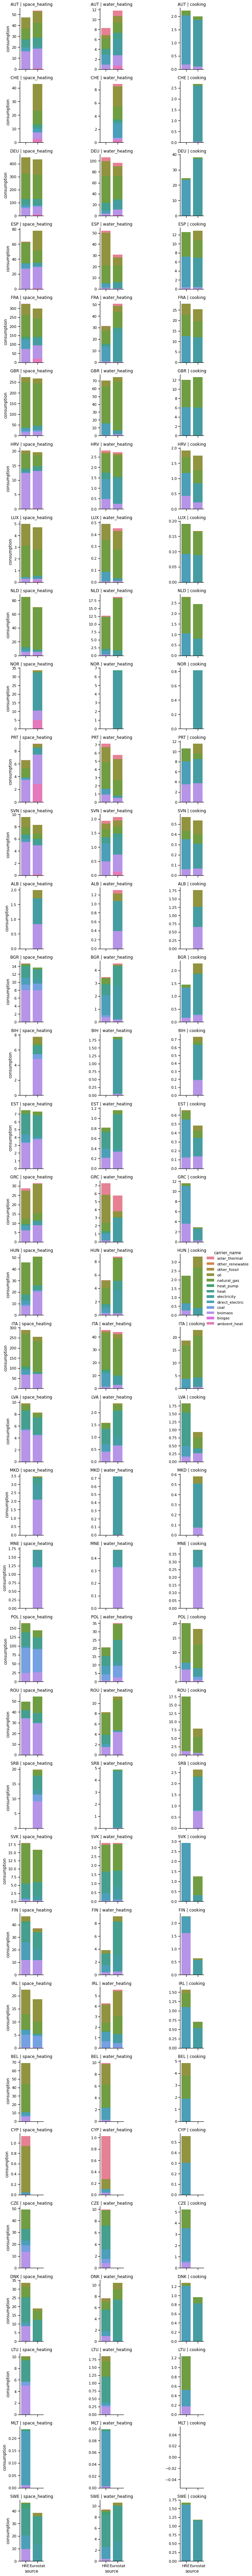

In [63]:
_df = (
    pd.concat([HRE_df, annual_consumption.apply(util.tj_to_twh)[2015]], names=['source'], keys=['HRE', 'Eurostat'])
    .unstack([0, 1, 3])
    .cumsum()
    .stack([0, 1, 2])
    .loc[idx[:, :, ['space_heating', 'water_heating', 'cooking', 'other_heating']]]
    .to_frame('consumption')
    .reset_index()
)
with sns.plotting_context("notebook", font_scale=1):
    g = sns.FacetGrid(
        _df, 
        col="cat_name", 
        row="country_code",
        hue="carrier_name", 
        hue_order=_df.carrier_name.unique()[::-1], 
        sharey=False
        #height=10, aspect=1.2
    )
    g.map(
        sns.barplot, 'source', 'consumption', 
        order=_df.source.unique()[::-1]
    )
    g.add_legend()#loc='center left', bbox_to_anchor=(0.5, 0.1))
    g.set_titles(col_template = '{col_name}', row_template = '{row_name}')
    #foo = [ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=8) for ax in g.axes.flat]

In [218]:
country_codes = {
    util.get_alpha2(i, eurostat=True): util.get_alpha3(i) for i in countries
}
energy_balance_df = pd.read_csv(
    energy_balance, index_col=[0, 1, 2, 3, 4], header=0, squeeze=True
)

annual_consumption = get_household_energy_consumption(
    hh_end_use, ch_end_use, country_codes
)

annual_consumption = get_commercial_energy_consumption(
    energy_balance_df, ch_end_use, country_codes,
    heat_tech_params, annual_consumption
)

/cluster/work/apatt/brynmorp/miniconda/envs/euro-spores/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [87]:
MNE_energy_balance = energy_balance_df.loc[idx[:, 'MNE'], :]
MNE_heat_electricity_consumption = MNE_energy_balance.loc['biomass'] * 0.28 / 0.69
MNE_energy_balance.loc['electricity'].update(MNE_heat_electricity_consumption)
neighbours = ['SRB', 'HRV', 'ALB', 'BIH']
neighbour_consumption = annual_consumption.loc[idx[END_USE_CAT_NAMES.values(), :, neighbours], :]
end_use_contributions = (
    neighbour_consumption
    .sum(level=['cat_name', 'country_code'])
    .div(neighbour_consumption.sum(level='country_code'))
    .mean(level='cat_name')
)
MNE_end_use = (
    end_use_contributions
    .stack().unstack('cat_name')
    .mul(MNE_energy_balance.stack(), axis=0)
    .stack().unstack('year')
    .rename_axis(index=['carrier_name', 'country_code', 'cat_name'])
    .reorder_levels(['cat_name', 'carrier_name', 'country_code'], axis=0)
)
MNE_end_use = MNE_end_use.where(MNE_end_use > 0).dropna(how='all')
annual_consumption = (annual_consumption.append(MNE_end_use, sort=True).sort_index())

In [104]:
def get_energy_balances(energy_balance, country_codes):
    energy_balance_df = pd.read_csv(
        energy_balance, index_col=[0, 1, 2, 3, 4], header=0, squeeze=True
    )
    balances = []
    for cat_name in ['FC_OTH_HH_E', 'FC_OTH_CP_E']:

        balances.append(
            energy_balance_df.xs((cat_name, 'TJ'), level=('cat_code', 'unit'))
            .unstack('year')
            .groupby([END_USE_CARRIER_NAMES, country_codes], level=['carrier_code', 'country'])
            .sum()
            .rename_axis(['carrier_name', 'country_code'], axis=0)
        )

    return balances

hh_energy_balance_df, cp_energy_balance_df = get_energy_balances(
    energy_balance, country_codes
)

/cluster/work/apatt/brynmorp/miniconda/envs/euro-spores/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [184]:
def fill_data_gaps(end_use_consumption, energy_balance_df, sector):
    if sector == 'hh':
        cat_names = list(END_USE_CAT_NAMES.values())
    elif sector == 'cp':
        cat_names = ['commercial_space_heating', 'commercial_water_heating']

    energy_balance_df = energy_balance_df.sum(level='country_code').stack()
    energy_balance_df = energy_balance_df.where(energy_balance_df > 0)
    end_use_consumption[cat_names] = end_use_consumption[cat_names].fillna(
        end_use_consumption[cat_names]
        .div(energy_balance_df, axis=0)
        .mean(level='country_code')
        .mul(energy_balance_df, level='country_code', axis=0)
    )
    return end_use_consumption

In [222]:
electricity_consumption.xs('MNE')

cat_name,commercial_space_heating,commercial_water_heating,cooking,space_heating,water_heating
year,,,,,
2000,NaN,NaN,NaN,NaN,NaN
2001,NaN,NaN,NaN,NaN,NaN
2002,NaN,NaN,NaN,NaN,NaN
2003,NaN,NaN,NaN,NaN,NaN
2004,NaN,NaN,NaN,NaN,NaN
2005,NaN,NaN,NaN,NaN,NaN
2006,NaN,NaN,NaN,NaN,NaN
2007,NaN,NaN,NaN,NaN,NaN
2008,NaN,NaN,NaN,NaN,NaN


In [219]:
electricity_consumption = (
    annual_consumption
    .loc[idx[:, ['electricity', 'direct_electric', 'heat_pump'], :], :]
    .sum(level=['cat_name', 'country_code'])
    .stack().unstack('cat_name')
)
electricity_consumption = electricity_consumption.where(electricity_consumption > 0)
#fill_data_gaps(electricity_consumption, hh_energy_balance_df, 'hh').xs('MNE')

In [190]:
electricity_consumption.xs('MNE')

cat_name,commercial_space_heating,commercial_water_heating,cooking,space_heating,water_heating
year,,,,,
2000,NaN,NaN,NaN,NaN,NaN
2001,NaN,NaN,NaN,NaN,NaN
2002,NaN,NaN,NaN,NaN,NaN
2003,NaN,NaN,NaN,NaN,NaN
2004,NaN,NaN,NaN,NaN,NaN
2005,6.874538,1.155848,NaN,NaN,NaN
2006,18.124347,3.047330,NaN,NaN,NaN
2007,7.447416,1.252168,NaN,NaN,NaN
2008,6.301660,1.059527,NaN,NaN,NaN


In [114]:
electricity_consumption.xs('ALB')

cat_name,commercial_space_heating,commercial_water_heating,cooking,space_heating,water_heating
year,,,,,
2000,193.921004,29.690644,NaN,NaN,NaN
2001,173.229659,24.409595,NaN,NaN,NaN
2002,176.786250,26.935586,NaN,NaN,NaN
2003,364.073941,51.835967,NaN,NaN,NaN
2004,548.300822,79.105698,NaN,NaN,NaN
2005,544.732118,76.227594,NaN,NaN,NaN
2006,248.451865,36.067565,NaN,NaN,NaN
2007,146.505135,24.036961,NaN,NaN,NaN
2008,325.904122,48.439392,NaN,NaN,NaN


In [ ]:
def fill_data_gaps(end_use_consumption, energy_balance_df, sector):
    if sector == 'hh':
        cat_names = list(END_USE_CAT_NAMES.values())
    elif sector == 'cp':
        cat_names = ['commercial_space_heating', 'commercial_water_heating']

    energy_balance_df = energy_balance_df.sum(level='country_code')
    energy_balance_df = energy_balance_df.where(energy_balance_df > 0)
    end_use_consumption[cat_names] = end_use_consumption[cat_names].fillna(
        energy_balance_df.mul(
            end_use_consumption[cat_names]
            .div(energy_balance_df, level='country_code')
            .mean(axis=1),
            level='country_code', axis=0
        )
    )
    return end_use_consumption

In [30]:
neighbours = ['SRB', 'HRV', 'ALB', 'BIH']
neighbour_consumption = annual_consumption.loc[idx[END_USE_CAT_NAMES.values(), :, neighbours], :]
end_use_contributions = (
    neighbour_consumption
    .sum(level=['cat_name', 'country_code'])
    .div(neighbour_consumption.sum(level='country_code'))
    .mean(level='cat_name')
)

In [81]:
MNE_end_use = (
    end_use_contributions
    .stack().unstack('cat_name')
    .mul(MNE_energy_balance.stack(), axis=0)
    .stack().unstack('year')
    .rename_axis(index=['carrier_name', 'country_code', 'cat_name'])
    .reorder_levels(['cat_name', 'carrier_name', 'country_code'], axis=0)
)
MNE_end_use = MNE_end_use.where(MNE_end_use > 0).dropna(how='all')

In [82]:
MNE_end_use

,,year,2010,2011,2012,2013,2014,2015,2016,2017,2018
cat_name,carrier_name,country_code,,,,,,,,,
cooking,biomass,MNE,1145.139741,1217.164437,1245.286413,1147.917640,968.495759,944.936765,923.294125,928.686191,808.526270
space_heating,biomass,MNE,4469.645909,4391.417948,4422.018177,4160.046716,4125.170099,4307.126120,4267.654862,4124.101557,3882.788878
water_heating,biomass,MNE,1047.214350,1169.417615,1193.695409,1193.035644,1183.334141,1169.937115,1117.051013,1156.212252,924.684852
cooking,coal,MNE,39.577968,23.154497,23.402890,17.888869,18.473474,20.327470,26.961125,14.050997,12.712694
space_heating,coal,MNE,154.478531,83.539308,83.103778,64.829154,78.685139,92.654854,124.619852,62.397544,61.050218
water_heating,coal,MNE,36.193501,22.246195,22.433331,18.591977,22.571387,25.167676,32.619023,17.493460,14.539089
cooking,electricity,MNE,464.694388,493.921801,505.333617,465.821651,393.012772,383.452600,374.670080,376.858164,328.097617
space_heating,electricity,MNE,1813.769354,1782.024674,1794.442159,1688.134899,1673.982069,1747.819295,1731.801973,1673.548458,1575.624472
water_heating,electricity,MNE,424.956548,474.546279,484.398137,484.130406,480.193565,474.757090,453.296063,469.187581,375.234433


In [83]:
annual_consumption.append(MNE_end_use, sort=True).sort_index().loc[idx[:, :, 'MNE'], :]

year                                                   2000  2001  2002  2003  \
cat_name                 carrier_name    country_code                           
commercial_space_heating biomass         MNE            NaN   NaN   NaN   NaN   
                         coal            MNE            NaN   NaN   NaN   NaN   
                         direct_electric MNE            NaN   NaN   NaN   NaN   
                         oil             MNE            NaN   NaN   NaN   NaN   
                         solar_thermal   MNE            NaN   NaN   NaN   NaN   
commercial_water_heating biomass         MNE            NaN   NaN   NaN   NaN   
                         coal            MNE            NaN   NaN   NaN   NaN   
                         direct_electric MNE            NaN   NaN   NaN   NaN   
                         oil             MNE            NaN   NaN   NaN   NaN   
                         solar_thermal   MNE            NaN   NaN   NaN   NaN   
cooking                  biomass         MNE            NaN   NaN   NaN   NaN   
                         coal            MNE            NaN   NaN   NaN   NaN   
                         electricity     MNE            NaN   NaN   NaN   NaN   
                         oil             MNE            NaN   NaN   NaN   NaN   
space_heating            biomass         MNE            NaN   NaN   NaN   NaN   
                         coal            MNE            NaN   NaN   NaN   NaN   
                         electricity     MNE            NaN   NaN   NaN   NaN   
                         oil             MNE            NaN   NaN   NaN   NaN   
water_heating            biomass         MNE            NaN   NaN   NaN   NaN   
                         coal            MNE            NaN   NaN   NaN   NaN   
                         electricity     MNE            NaN   NaN   NaN   NaN   
                         oil             MNE            NaN   NaN   NaN   NaN   

year                                                   2004       2005  \
cat_name                 carrier_name    country_code                    
commercial_space_heating biomass         MNE            NaN        NaN   
                         coal            MNE            NaN  96.952818   
                         direct_electric MNE            NaN        NaN   
                         oil             MNE            NaN        NaN   
                         solar_thermal   MNE            NaN        NaN   
commercial_water_heating biomass         MNE            NaN        NaN   
                         coal            MNE            NaN  13.567182   
                         direct_electric MNE            NaN        NaN   
                         oil             MNE            NaN        NaN   
                         solar_thermal   MNE            NaN        NaN   
cooking                  biomass         MNE            NaN        NaN   
                         coal            MNE            NaN        NaN   
                         electricity     MNE            NaN        NaN   
                         oil             MNE            NaN        NaN   
space_heating            biomass         MNE            NaN        NaN   
                         coal            MNE            NaN        NaN   
                         electricity     MNE            NaN        NaN   
                         oil             MNE            NaN        NaN   
water_heating            biomass         MNE            NaN        NaN   
                         coal            MNE            NaN        NaN   
                         electricity     MNE            NaN        NaN   
                         oil             MNE            NaN        NaN   

year                                                         2006        2007  \
cat_name                 carrier_name    country_code                           
commercial_space_heating biomass         MNE                  NaN         NaN   
                         coal      

In [61]:
annual_consumption.loc[idx[:, :, 'MNE'], :]

year                                                   2000  2001  2002  2003  \
cat_name                 carrier_name    country_code                           
commercial_water_heating biomass         MNE            NaN   NaN   NaN   NaN   
                         coal            MNE            NaN   NaN   NaN   NaN   
                         oil             MNE            NaN   NaN   NaN   NaN   
                         solar_thermal   MNE            NaN   NaN   NaN   NaN   
                         direct_electric MNE            NaN   NaN   NaN   NaN   
commercial_space_heating biomass         MNE            NaN   NaN   NaN   NaN   
                         coal            MNE            NaN   NaN   NaN   NaN   
                         oil             MNE            NaN   NaN   NaN   NaN   
                         solar_thermal   MNE            NaN   NaN   NaN   NaN   
                         direct_electric MNE            NaN   NaN   NaN   NaN   

year                                                   2004       2005  \
cat_name                 carrier_name    country_code                    
commercial_water_heating biomass         MNE            NaN        NaN   
                         coal            MNE            NaN  13.567182   
                         oil             MNE            NaN        NaN   
                         solar_thermal   MNE            NaN        NaN   
                         direct_electric MNE            NaN        NaN   
commercial_space_heating biomass         MNE            NaN        NaN   
                         coal            MNE            NaN  96.952818   
                         oil             MNE            NaN        NaN   
                         solar_thermal   MNE            NaN        NaN   
                         direct_electric MNE            NaN        NaN   

year                                                         2006        2007  \
cat_name                 carrier_name    country_code                           
commercial_water_heating biomass         MNE                  NaN         NaN   
                         coal            MNE            31.523054   16.875279   
                         oil             MNE             5.414202         NaN   
                         solar_thermal   MNE                  NaN         NaN   
                         direct_electric MNE                  NaN         NaN   
commercial_space_heating biomass         MNE                  NaN         NaN   
                         coal            MNE           217.146946  102.854721   
                         oil             MNE            37.295798         NaN   
                         solar_thermal   MNE                  NaN         NaN   
                         direct_electric MNE                  NaN         NaN   

year                                                        2008        2009  \
cat_name                 carrier_name    country_code                          
commercial_water_heating biomass         MNE                 NaN         NaN   
                         coal            MNE           13.109336   21.932685   
                         oil             MNE                 NaN         NaN   
                         solar_thermal   MNE                 NaN         NaN   
                         direct_electric MNE                 NaN         NaN   
commercial_space_heating biomass         MNE                 NaN         NaN   
                         coal            MNE           88.200664  143.847315   
                         oil             MNE                 NaN         NaN   
                         solar_thermal   MNE                 NaN         NaN   
                         direct_electric MNE                 NaN         NaN   

year                                                         2010        2011  \
cat_name                 carrier_name    country_code                           
commercial_water_heating biomass         M

In [47]:
annual_consumption.loc[idx[:, :, 'MNE'], :]

year                                                   2000  2001  2002  2003  \
cat_name                 carrier_name    country_code                           
commercial_water_heating biomass         MNE            NaN   NaN   NaN   NaN   
                         coal            MNE            NaN   NaN   NaN   NaN   
                         oil             MNE            NaN   NaN   NaN   NaN   
                         solar_thermal   MNE            NaN   NaN   NaN   NaN   
                         direct_electric MNE            NaN   NaN   NaN   NaN   
commercial_space_heating biomass         MNE            NaN   NaN   NaN   NaN   
                         coal            MNE            NaN   NaN   NaN   NaN   
                         oil             MNE            NaN   NaN   NaN   NaN   
                         solar_thermal   MNE            NaN   NaN   NaN   NaN   
                         direct_electric MNE            NaN   NaN   NaN   NaN   

year                                                   2004       2005  \
cat_name                 carrier_name    country_code                    
commercial_water_heating biomass         MNE            NaN        NaN   
                         coal            MNE            NaN  13.567182   
                         oil             MNE            NaN        NaN   
                         solar_thermal   MNE            NaN        NaN   
                         direct_electric MNE            NaN        NaN   
commercial_space_heating biomass         MNE            NaN        NaN   
                         coal            MNE            NaN  96.952818   
                         oil             MNE            NaN        NaN   
                         solar_thermal   MNE            NaN        NaN   
                         direct_electric MNE            NaN        NaN   

year                                                         2006        2007  \
cat_name                 carrier_name    country_code                           
commercial_water_heating biomass         MNE                  NaN         NaN   
                         coal            MNE            31.523054   16.875279   
                         oil             MNE             5.414202         NaN   
                         solar_thermal   MNE                  NaN         NaN   
                         direct_electric MNE                  NaN         NaN   
commercial_space_heating biomass         MNE                  NaN         NaN   
                         coal            MNE           217.146946  102.854721   
                         oil             MNE            37.295798         NaN   
                         solar_thermal   MNE                  NaN         NaN   
                         direct_electric MNE                  NaN         NaN   

year                                                        2008        2009  \
cat_name                 carrier_name    country_code                          
commercial_water_heating biomass         MNE                 NaN         NaN   
                         coal            MNE           13.109336   21.932685   
                         oil             MNE                 NaN         NaN   
                         solar_thermal   MNE                 NaN         NaN   
                         direct_electric MNE                 NaN         NaN   
commercial_space_heating biomass         MNE                 NaN         NaN   
                         coal            MNE           88.200664  143.847315   
                         oil             MNE                 NaN         NaN   
                         solar_thermal   MNE                 NaN         NaN   
                         direct_electric MNE                 NaN         NaN   

year                                                         2010        2011  \
cat_name                 carrier_name    country_code                           
commercial_water_heating biomass         M

In [7]:
demand_tdf = demand.loc[idx[:, population.index], :].stack(dropna=False).unstack('cat_name')

# Add heating degree days
areas = hdd.area
country_hdd = hdd.dropna().groupby('id').agg(lambda x: np.average(x, weights=areas.loc[x.index])).drop(columns='population')
country_hdd.columns = country_hdd.columns.astype(int).rename('year')
country_hdd_tdf = country_hdd.rename_axis('country_code', axis=0).stack()
demand_tdf = demand_tdf.assign(hdd=country_hdd.rename_axis('country_code', axis=0).stack())

# Add population
demand_tdf['population'] = demand_tdf.assign(population=1).population.mul(population.population_sum, level='country_code')

# Add annual consumption
end_uses = {
    'E7000': 'electricity',
    'G3000': 'natural_gas',
    'H8000': 'heat',
    'O4000XBIO': 'oil',
    'R5110-5150_W6000RI': 'biomass',
    'R5300': 'biogas',
    'RA410': 'solar_thermal',
    'RA600': 'ambient_heat',
    'P1000': 'coal',
    'S2000': 'coal',
    'W6100_6220': 'biomass'
    'C0000X0350-0370': 'coal'
}
efficiencies = pd.Series({
    'biogas': heat_tech_params['natural_gas_eff'],
    'biomass': heat_tech_params['wood_eff'],
    'coal': heat_tech_params['coal_eff'],
    'natural_gas': heat_tech_params['natural_gas_eff'],
    'oil': heat_tech_params['oil_eff'],
    'solar_thermal': heat_tech_params['solar_thermal_eff'],
    'direct_electric': 1,  # don't need to deal with heat pump COP if direct electric is 100% efficient
    'heat': 1,
    'electricity': 1,
    # heat demand met by heat pumps = heat pump electricity + ambient heat
    'heat_pump': 1,
    'ambient_heat': 1
})


hh_consumption = annual_consumption.xs(('FC_OTH_HH_E', 'TJ'), level=('cat_code', 'unit')).unstack(0)[list(end_uses.keys())]
hh_consumption.columns = hh_consumption.columns.map(end_uses).rename('carrier_name')


hh_demand = hh_consumption.stack().mul(
    efficiencies, level='carrier_name', axis=0
).sum(level=('country', 'year'))
hh_demand.index = hh_demand.index.set_levels(hh_demand.index.levels[0].map(util.get_alpha3), level='country').set_names('country_code', level='country')

demand_tdf = demand_tdf.assign(hh_demand=hh_demand)

In [55]:
foo = annual_consumption.xs(('FC_OTH_HH_E', 'TJ'), level=('cat_code', 'unit')).unstack('year').groupby([END_USE_CARRIER_NAMES, country_codes], level=['carrier_code', 'country']).sum().stack()

In [78]:
energy_balance_df.xs('MNE', level='country')[2004]

carrier_code
ambient_heat     0.0
biogas           0.0
biomass          0.0
coal             0.0
electricity      0.0
heat             0.0
natural_gas      0.0
oil              0.0
solar_thermal    0.0
Name: 2004, dtype: float64

In [91]:
demand_gapfilled = demand.fillna(

demand.div(
    foo.mul(
        efficiencies, level='carrier_code', axis=0
    ).sum(level=('country', 'year')).reindex(demand.index),
    axis=0
).dropna().mean(level=0).mul(
    foo.mul(
        efficiencies, level='carrier_code', axis=0
    ).sum(level=('country', 'year')).reindex(demand.index),
    level='country_code', axis=0
)
)
demand_gapfilled = demand_gapfilled.where(demand_gapfilled > 0)

In [103]:
demand_gapfilled = demand_gapfilled.fillna(demand_gapfilled.mean(level=0))

In [107]:
demand_gapfilled.div(population.population_sum, level='country_code', axis=0)

cat_name            cooking  space_heating  water_heating
country_code                                             
ALB          2000  0.001457       0.001572       0.001044
             2001  0.001448       0.001563       0.001038
             2002  0.002254       0.002433       0.001616
             2003  0.001473       0.001589       0.001056
             2004  0.002073       0.002237       0.001486
...                     ...            ...            ...
SWE          2014  0.000443       0.014562       0.003973
             2015  0.000441       0.014193       0.003932
             2016  0.000441       0.015096       0.004180
             2017  0.000478       0.014717       0.004086
             2018  0.000500       0.017080       0.004471

[627 rows x 3 columns]

rmse: 20193.258721673254


<BarContainer object of 35 artists>

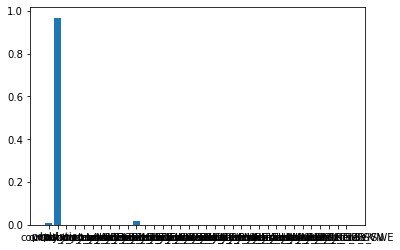

In [75]:
_data = pd.get_dummies(demand_tdf.dropna().sample(frac=1).reset_index())
x_train, x_test, y_train, y_test = train_test_split(_data.filter(regex='country_code|hdd|population'), _data['hh_demand'], test_size=0.1, random_state=23)
rand_forest_model = RandomForestRegressor(random_state=23, max_depth=None, n_estimators=500, oob_score=True)
rand_forest_model.fit(x_train, y_train)
y_pred = rand_forest_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f'rmse: {np.sqrt(mse)}')
imp = rand_forest_model.feature_importances_
plt.bar(x=_data.filter(regex='country_code|hdd|population').columns, height=imp)

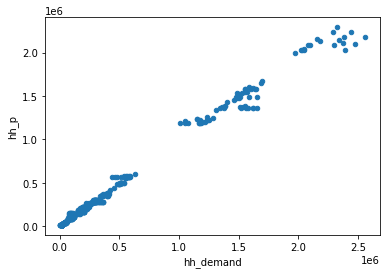

In [112]:
prediction = rand_forest_model.predict(pd.get_dummies(demand_tdf.reset_index()).filter(regex='country_code|hdd|population'))
foo = demand_tdf.assign(hh_p=prediction)
foo.plot.scatter(x='hh_demand', y='hh_p')

In [240]:
demand_tdf.dropna().corr()

cat_name,cooking,space_heating,water_heating,hdd,population,hh_demand,lc_11,lc_14,lc_20,lc_30,...,lc_120,lc_130,lc_140,lc_150,lc_180,lc_190,lc_200,lc_210,lc_220,lc_230
cat_name,,,,,,,,,,,,,,,,,,,,,
cooking,1.000000,0.910157,0.899847,-0.253172,0.915399,0.913710,0.182755,0.778289,0.709921,0.777023,...,0.694183,0.184298,0.325966,-0.094548,-0.147566,0.775610,-0.084103,-0.016549,-0.125658,-0.115928
space_heating,0.910157,1.000000,0.966852,-0.084356,0.951121,0.993303,-0.003787,0.763001,0.538839,0.688371,...,0.746614,-0.039564,0.560805,-0.065405,-0.073744,0.866655,-0.042147,0.071214,-0.063364,-0.070033
water_heating,0.899847,0.966852,1.000000,-0.123615,0.965095,0.976275,0.107289,0.695386,0.544975,0.662358,...,0.688988,0.080498,0.610734,-0.059152,-0.079218,0.918305,-0.050680,0.075918,-0.086873,-0.083959
hdd,-0.253172,-0.084356,-0.123615,1.000000,-0.233822,-0.121790,-0.367653,-0.251548,-0.354374,-0.303441,...,-0.011019,-0.403270,-0.100779,0.522311,0.642974,-0.217522,0.510834,0.528857,0.580951,0.470832
population,0.915399,0.951121,0.965095,-0.233822,1.000000,0.970673,0.243525,0.808811,0.695192,0.786525,...,0.745916,0.213476,0.577171,-0.070191,-0.130376,0.936039,-0.064522,0.031767,-0.116257,-0.110909
hh_demand,0.913710,0.993303,0.976275,-0.121790,0.970673,1.000000,0.075668,0.770961,0.565799,0.723126,...,0.770133,0.043477,0.579506,-0.052337,-0.069767,0.897043,-0.037255,0.080869,-0.069437,-0.074379
lc_11,0.182755,-0.003787,0.107289,-0.367653,0.243525,0.075668,1.000000,0.167672,0.602629,0.441748,...,0.089754,0.973766,-0.105673,0.102456,-0.093254,0.245997,0.029553,-0.053157,-0.080381,-0.030199
lc_14,0.778289,0.763001,0.695386,-0.251548,0.808811,0.770961,0.167672,1.000000,0.780606,0.928344,...,0.852304,0.155398,0.348210,-0.107830,-0.163284,0.628157,-0.081942,-0.035023,-0.141026,-0.126510
lc_20,0.709921,0.538839,0.544975,-0.354374,0.695192,0.565799,0.602629,0.780606,1.000000,0.858776,...,0.524472,0.575225,0.013397,-0.070362,-0.205907,0.541075,-0.090552,-0.092037,-0.179955,-0.156737


In [115]:
demand_tdf.dropna().corr(method='spearman')

cat_name,cooking,space_heating,water_heating,hdd,population,hh_demand
cat_name,,,,,,
cooking,1.000000,0.746330,0.807343,-0.416862,0.915784,0.809996
space_heating,0.746330,1.000000,0.957545,0.034414,0.882070,0.973615
water_heating,0.807343,0.957545,1.000000,-0.060029,0.935647,0.988001
hdd,-0.416862,0.034414,-0.060029,1.000000,-0.296149,-0.055687
population,0.915784,0.882070,0.935647,-0.296149,1.000000,0.935745
hh_demand,0.809996,0.973615,0.988001,-0.055687,0.935745,1.000000


In [116]:
demand_tdf.dropna().corr(method='kendall')

cat_name,cooking,space_heating,water_heating,hdd,population,hh_demand
cat_name,,,,,,
cooking,1.000000,0.572970,0.641448,-0.269600,0.750233,0.636570
space_heating,0.572970,1.000000,0.830027,0.032316,0.714454,0.897191
water_heating,0.641448,0.830027,1.000000,-0.036537,0.798850,0.908259
hdd,-0.269600,0.032316,-0.036537,1.000000,-0.186624,-0.030908
population,0.750233,0.714454,0.798850,-0.186624,1.000000,0.792460
hh_demand,0.636570,0.897191,0.908259,-0.030908,0.792460,1.000000


In [167]:
# Have a look at land cover as well
land_cover = pd.read_csv('/cluster/home/brynmorp/work/cpesm/brynmorp/possibility-for-electricity-autarky/build/national/land-cover.csv', index_col=0).dropna(how='all', axis=1).fillna(0)
demand_tdf = demand_tdf.assign(**{i: 1 for i in land_cover.columns})
demand_tdf[land_cover.columns] = demand_tdf[land_cover.columns].mul(land_cover, level='country_code', axis=0)

cooking, rmse: 2539.628546438908
space_heating, rmse: 31210.077049508363
water_heating, rmse: 6921.054647793669
hh_demand, rmse: 30303.17278612856


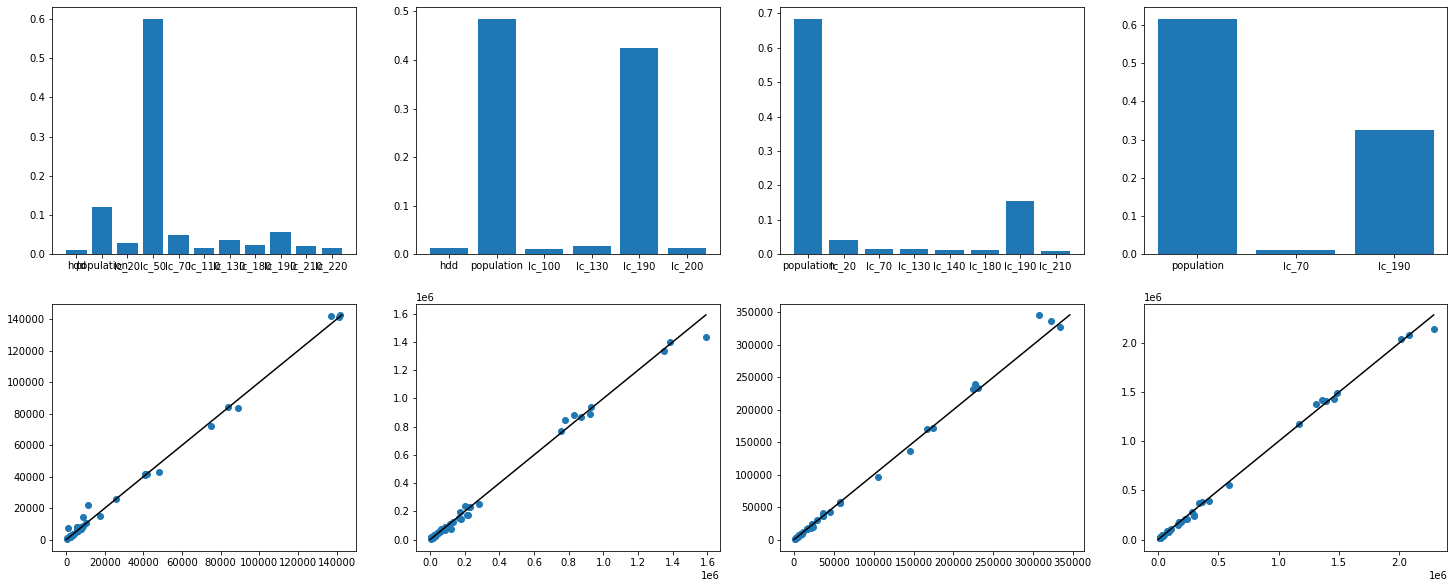

In [210]:
_data = demand_tdf.dropna().sample(frac=1)
fig, ax = plt.subplots(2, 4, figsize=(25, 10))
_ax = 0
features = 'hdd|population|lc_'
i = 'hh_demand'
x_train, x_test, y_train, y_test = train_test_split(_data.filter(regex=features), _data[i], test_size=0.2, random_state=23)
rand_forest_model = RandomForestRegressor(max_depth=None, n_estimators=100, oob_score=True, random_state=23)
rand_forest_model.fit(x_train, y_train)
y_pred = rand_forest_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f'{i}, rmse: {np.sqrt(mse)}')
imp = rand_forest_model.feature_importances_
imp[imp < 0.01] = np.nan
ax[0, _ax].bar(x=_data.filter(regex=features).columns[~np.isnan(imp)], height=imp[~np.isnan(imp)])

prediction = rand_forest_model.predict(x_test)
ax[1, _ax].scatter(x=y_test, y=prediction)
ax[1, _ax].plot([0, max([prediction.max(), y_test.max()])], [0, max([prediction.max(), y_test.max()])], c='black')
_ax += 1
eurospores_tdf[i] = rand_forest_model.predict(eurospores_tdf[_data.filter(regex=features).columns])

for i in ['cooking', 'space_heating', 'water_heating']:
    x_train, x_test, y_train, y_test = train_test_split(_data.filter(regex=features), _data[i], test_size=0.2, random_state=23)
    rand_forest_model = RandomForestRegressor(max_depth=None, n_estimators=100, oob_score=True, random_state=23)
    rand_forest_model.fit(x_train, y_train)
    y_pred = rand_forest_model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'{i}, rmse: {np.sqrt(mse)}')
    imp = rand_forest_model.feature_importances_
    imp[imp < 0.01] = np.nan
    ax[0, _ax].bar(x=_data.filter(regex=features).columns[~np.isnan(imp)], height=imp[~np.isnan(imp)])
    
    prediction = rand_forest_model.predict(x_test)
    ax[1, _ax].scatter(x=y_test, y=prediction)
    ax[1, _ax].plot([0, max([prediction.max(), y_test.max()])], [0, max([prediction.max(), y_test.max()])], c='black')
    _ax += 1
    eurospores_tdf[i] = rand_forest_model.predict(eurospores_tdf[_data.filter(regex=features).columns])

In [168]:
hh_demand_filled = demand_tdf.filter(regex='cooking|_heating').fillna((demand_tdf.filter(regex='cooking|_heating').div(demand_tdf.hh_demand, axis=0)).dropna().mean(level=0).mul(demand_tdf.hh_demand, level='country_code', axis=0))

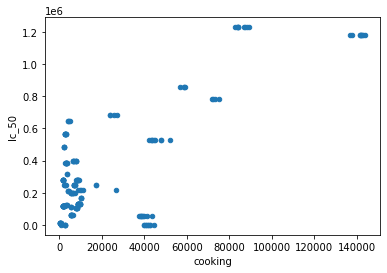

In [175]:
demand_tdf.plot.scatter(x='cooking', y='lc_50')

In [102]:
units_eurospores = gpd.read_file('/cluster/work/cpesm/brynmorp/euro-spores/land-eligibility/build/eurospores/units.geojson')
population_eurospores = pd.read_csv('../land-eligibility/build/eurospores/population.csv', index_col=0).rename_axis('country_code', axis=0)
demand_gapfilled.div(population, axis=0, level='country_code')

cooking  density_p_per_km2  population_sum  space_heating  \
country_code                                                                   
ALB          2000      NaN                NaN             NaN            NaN   
             2001      NaN                NaN             NaN            NaN   
             2002      NaN                NaN             NaN            NaN   
             2003      NaN                NaN             NaN            NaN   
             2004      NaN                NaN             NaN            NaN   
...                    ...                ...             ...            ...   
SWE          2014      NaN                NaN             NaN            NaN   
             2015      NaN                NaN             NaN            NaN   
             2016      NaN                NaN             NaN            NaN   
             2017      NaN                NaN             NaN            NaN   
             2018      NaN                NaN             NaN            NaN   

                   water_heating  
country_code                      
ALB          2000            NaN  
             2001            NaN  
             2002            NaN  
             2003            NaN  
             2004            NaN  
...                          ...  
SWE          2014            NaN  
             2015            NaN  
             2016            NaN  
             2017            NaN  
             2018            NaN  

[627 rows x 5 columns]

In [13]:
#national_annual_demand_ratio = demand_gapfilled.div(population.population_sum, level='country_code', axis=0)
population_df = pd.read_csv('../land-eligibility/build/eurospores/population.csv', index_col='id')
id_to_country = gpd.read_file('/cluster/work/cpesm/brynmorp/euro-spores/land-eligibility/build/eurospores/units.geojson').set_index('id').country_code


In [16]:
demand.xs(2017, level=1).reindex(id_to_country).mul(population_df.set_index(id_to_country).population_sum, axis=0).set_index(id_to_country.index).stack().xs('BEL_1')

cat_name
commercial_space_heating    25.466392
commercial_water_heating     4.284237
cooking                      1.502446
space_heating               59.551744
water_heating                9.977641
dtype: float64

In [241]:
# Get Eurospores data
units_eurospores = gpd.read_file('/cluster/work/cpesm/brynmorp/euro-spores/land-eligibility/build/eurospores/units.geojson')
population_eurospores = pd.read_csv('../land-eligibility/build/eurospores/population.csv', index_col=0).rename_axis('country_code', axis=0)

hdd_eurospores = gpd.overlay(units_eurospores, hdd)
areas = hdd_eurospores.area
eurospores_tdf = hdd_eurospores.dropna().groupby(['id_1', 'country_code_1']).agg(lambda x: np.average(x, weights=areas.loc[x.index])).drop(columns=['population', 'proper']).stack().to_frame('hdd')
eurospores_tdf.index.set_names(['id', 'country_code', 'year'], inplace=True)
eurospores_tdf.index.set_levels(eurospores_tdf.index.levels[-1].astype(int), level='year', inplace=True)
eurospores_tdf['population'] = eurospores_tdf.assign(population=1).population.mul(population_eurospores.population_sum, level='id')

land_cover = pd.read_csv('/cluster/home/brynmorp/work/cpesm/brynmorp/euro-spores/land-eligibility/build/eurospores/land-cover.csv', index_col=0).dropna(how='all', axis=1).fillna(0)
eurospores_tdf = eurospores_tdf.assign(**{i: 1 for i in land_cover.columns})
eurospores_tdf[land_cover.columns] = eurospores_tdf[land_cover.columns].mul(land_cover, level='id', axis=0)

# Get demand based on population weighting
hh_demand_ratio = hh_demand_filled.div(demand_tdf.population, axis=0)
hh_demand_ratio.index.set_names(['country_code', 'year'], inplace=True)
eurospores_tdf = pd.concat(
    [eurospores_tdf, 
     hh_demand_ratio
     .reindex(eurospores_tdf.reset_index('id').index)
     .mul(eurospores_tdf.population.values, axis=0)
     .set_index(eurospores_tdf.index)
    ], 
    axis=1
)

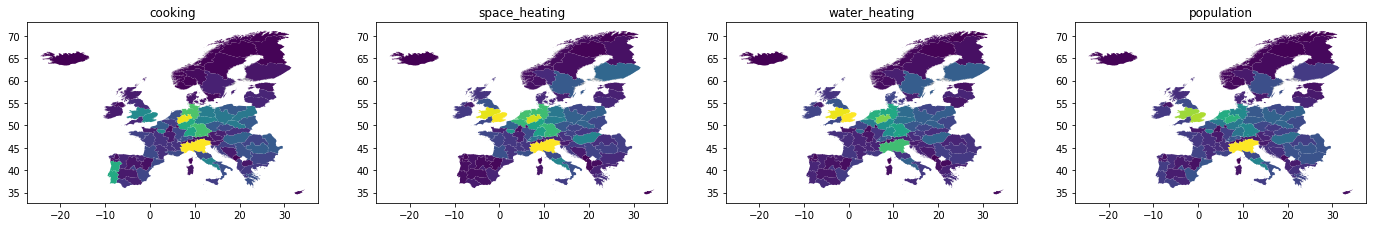

In [306]:
# Plot the average demand for cooking, space heating, and water heating
fig, ax = plt.subplots(1, 4, figsize=(24, 10))
foo = units_eurospores.set_index('id').assign(**{i: eurospores_tdf.mean(level='id')[i] for i in ['cooking', 'space_heating', 'water_heating', 'population']}).fillna(0)
_ax = 0
for i in ['cooking', 'space_heating', 'water_heating', 'population']:
    foo.plot(i, ax=ax[_ax])
    ax[_ax].set_title(i)
    _ax += 1

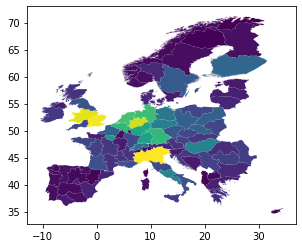

In [298]:
# Plot the average demand for space heating
units_eurospores.set_index('id').assign(**{i: eurospores_tdf.mean(level='id')[i] for i in ['cooking', 'space_heating', 'water_heating']}).plot('space_heating')

In [232]:
eurospores_tdf.groupby([units_eurospores.set_index('id')['country_code'].to_dict(), {i: i for i in eurospores_tdf.index.levels[1]}], level=[0, 1]).sum().xs('ITA')

,hdd,population,lc_11,lc_14,lc_20,lc_30,lc_40,lc_50,lc_60,lc_70,...,lc_180,lc_190,lc_200,lc_210,lc_220,lc_230,cooking,space_heating,water_heating,hh_demand
2000,7426.138053,5.924383e+07,45353.0,916335.0,1244368.0,290808.0,0.0,782718.0,0.0,148568.0,...,391.0,166446.0,17761.0,52108.0,3243.0,0.0,64145.486061,526818.469623,123054.967607,893026.346258
2001,7704.964913,5.924383e+07,45353.0,916335.0,1244368.0,290808.0,0.0,782718.0,0.0,148568.0,...,391.0,166446.0,17761.0,52108.0,3243.0,0.0,64016.141956,547720.375442,123530.749046,901987.996850
2002,7071.288426,5.924383e+07,45353.0,916335.0,1244368.0,290808.0,0.0,782718.0,0.0,148568.0,...,391.0,166446.0,17761.0,52108.0,3243.0,0.0,64444.304295,528254.084267,123219.350013,886541.275054
2003,8302.620849,5.924383e+07,45353.0,916335.0,1244368.0,290808.0,0.0,782718.0,0.0,148568.0,...,391.0,166446.0,17761.0,52108.0,3243.0,0.0,63805.184202,551060.993236,122982.122708,901213.114308
2004,8123.741335,5.924383e+07,45353.0,916335.0,1244368.0,290808.0,0.0,782718.0,0.0,148568.0,...,391.0,166446.0,17761.0,52108.0,3243.0,0.0,63748.792292,552075.497571,123038.401951,900648.405596
2005,9107.268426,5.924383e+07,45353.0,916335.0,1244368.0,290808.0,0.0,782718.0,0.0,148568.0,...,391.0,166446.0,17761.0,52108.0,3243.0,0.0,66252.140416,585507.887827,122764.138724,908102.698437
2006,7919.250133,5.924383e+07,45353.0,916335.0,1244368.0,290808.0,0.0,782718.0,0.0,148568.0,...,391.0,166446.0,17761.0,52108.0,3243.0,0.0,63579.442716,546368.186583,124274.503029,901554.613037
2007,7190.582245,5.924383e+07,45353.0,916335.0,1244368.0,290808.0,0.0,782718.0,0.0,148568.0,...,391.0,166446.0,17761.0,52108.0,3243.0,0.0,64045.197324,528254.084267,122830.035828,886541.275054
2008,7633.427174,5.924383e+07,45353.0,916335.0,1244368.0,290808.0,0.0,782718.0,0.0,148568.0,...,391.0,166446.0,17761.0,52108.0,3243.0,0.0,63883.285426,533634.993055,123152.692692,893026.346258
2009,8039.262578,5.924383e+07,45353.0,916335.0,1244368.0,290808.0,0.0,782718.0,0.0,148568.0,...,391.0,166446.0,17761.0,52108.0,3243.0,0.0,63619.820480,549361.672069,123038.401951,900648.405596


In [233]:
demand_tdf.xs('ITA')

cat_name,cooking,space_heating,water_heating,hdd,population,hh_demand,lc_11,lc_14,lc_20,lc_30,...,lc_120,lc_130,lc_140,lc_150,lc_180,lc_190,lc_200,lc_210,lc_220,lc_230
2000,NaN,NaN,NaN,1622.214018,59224384.0,1.007573e+06,45350.0,916281.0,1244261.0,290721.0,...,93704,79608.0,22425,281278,213.0,166230,17599,43354,3232.0,0.0
2001,NaN,NaN,NaN,1697.990014,59224384.0,1.054690e+06,45350.0,916281.0,1244261.0,290721.0,...,93704,79608.0,22425,281278,213.0,166230,17599,43354,3232.0,0.0
2002,NaN,NaN,NaN,1560.778179,59224384.0,1.050168e+06,45350.0,916281.0,1244261.0,290721.0,...,93704,79608.0,22425,281278,213.0,166230,17599,43354,3232.0,0.0
2003,NaN,NaN,NaN,1788.850113,59224384.0,1.149978e+06,45350.0,916281.0,1244261.0,290721.0,...,93704,79608.0,22425,281278,213.0,166230,17599,43354,3232.0,0.0
2004,NaN,NaN,NaN,1771.471432,59224384.0,1.148927e+06,45350.0,916281.0,1244261.0,290721.0,...,93704,79608.0,22425,281278,213.0,166230,17599,43354,3232.0,0.0
2005,NaN,NaN,NaN,1930.375923,59224384.0,1.234672e+06,45350.0,916281.0,1244261.0,290721.0,...,93704,79608.0,22425,281278,213.0,166230,17599,43354,3232.0,0.0
2006,NaN,NaN,NaN,1719.555345,59224384.0,1.178445e+06,45350.0,916281.0,1244261.0,290721.0,...,93704,79608.0,22425,281278,213.0,166230,17599,43354,3232.0,0.0
2007,NaN,NaN,NaN,1568.815328,59224384.0,1.171519e+06,45350.0,916281.0,1244261.0,290721.0,...,93704,79608.0,22425,281278,213.0,166230,17599,43354,3232.0,0.0
2008,NaN,NaN,NaN,1671.348952,59224384.0,1.216682e+06,45350.0,916281.0,1244261.0,290721.0,...,93704,79608.0,22425,281278,213.0,166230,17599,43354,3232.0,0.0
2009,NaN,NaN,NaN,1749.359462,59224384.0,1.232249e+06,45350.0,916281.0,1244261.0,290721.0,...,93704,79608.0,22425,281278,213.0,166230,17599,43354,3232.0,0.0


In [293]:
units_eurospores.assign()

,id,country_code,name,type,proper,geometry
0,ALB_1,ALB,Albania,country,True,"MULTIPOLYGON (((19.59271 41.63155, 19.59264 41..."
1,AUT_1,AUT,eurospores_cluster,eurospores_cluster,True,"MULTIPOLYGON (((14.23342 46.70017, 14.23142 46..."
2,AUT_2,AUT,eurospores_cluster,eurospores_cluster,True,"MULTIPOLYGON (((14.23342 46.70017, 14.23618 46..."
3,AUT_3,AUT,eurospores_cluster,eurospores_cluster,True,"MULTIPOLYGON (((15.99580 46.83480, 15.99624 46..."
4,BEL_1,BEL,Belgium,country,True,"MULTIPOLYGON (((6.20684 50.52040, 6.20940 50.5..."
...,...,...,...,...,...,...
93,SVN_1,SVN,Slovenia,country,True,"MULTIPOLYGON (((13.59713 45.81952, 13.59238 45..."
94,SWE_1,SWE,eurospores_cluster,eurospores_cluster,True,"MULTIPOLYGON (((22.75127 65.85733, 22.75114 65..."
95,SWE_2,SWE,eurospores_cluster,eurospores_cluster,True,"MULTIPOLYGON (((17.55378 60.73088, 17.55417 60..."
96,SWE_3,SWE,eurospores_cluster,eurospores_cluster,True,"MULTIPOLYGON (((16.25638 56.61597, 16.25801 56..."


In [266]:
eurospores_tdf.shape

(1862, 25)

cat_name,cooking,space_heating,water_heating
year,,,
2000,4193.548441,4525.522376,3006.519807
2001,4168.506448,4498.497983,2988.566217
2002,6489.258386,7002.967640,4652.404555
2003,4239.473613,4575.083123,3039.445369
2004,5967.815191,6440.245430,4278.561420
2005,5628.774257,6074.364993,4035.489640
2006,4838.312417,5221.327812,3468.776459
2007,4568.033765,4929.653087,3275.003064
2008,4842.383300,5225.720958,3471.695035


In [286]:
foo.xs('ALB')

cat_name,cooking,space_heating,water_heating
year,,,
2000,0.001457,0.001572,0.001045
2001,0.001448,0.001563,0.001038
2002,0.002255,0.002433,0.001617
2003,0.001473,0.001590,0.001056
2004,0.002074,0.002238,0.001487
2005,0.001956,0.002111,0.001402
2006,0.001681,0.001814,0.001205
2007,0.001587,0.001713,0.001138
2008,0.001683,0.001816,0.001206
